In [1]:
from pathlib import Path
from collections import deque
import json
import re
from slpp import slpp as lua
from dataclasses import dataclass, field
from graphviz import Digraph
import networkx as nx
import tkinter as tk
import pygraphviz as pgv

In [2]:
text = Path("data/recipe.lua").read_text()

# Remove wrapper
text = text.removeprefix("data:extend(\n").removesuffix(")\n")
text = text.strip()

# Remove comments
text = re.sub(r"--.*", "", text)

raw_recipes = lua.decode(text)

Path("data/recipe.json").write_text(json.dumps(raw_recipes, indent=2))

raw_recipe_keys = raw_recipe_keys = {key for recipe in raw_recipes for key in recipe.keys()}

print(len(raw_recipes))
print(raw_recipe_keys)

198
{'crafting_machine_tint', 'icon_size', 'name', 'main_product', 'icon', 'hidden', 'allow_decomposition', 'category', 'result', 'enabled', 'normal', 'result_count', 'expensive', 'results', 'subgroup', 'icon_mipmaps', 'ingredients', 'order', 'energy_required', 'type', 'requester_paste_multiplier'}


In [3]:
@dataclass
class Recipe:
    name: str
    ingredients: dict[str, int] = field(default_factory=dict)
    energy_required: float = 0.5
    result_count: float = 1

DIFFICULTY = "normal"
recipes: dict[str, Recipe] = {}
for raw_recipe in raw_recipes:
    name = raw_recipe["name"]
    amount_dict = raw_recipe.get(DIFFICULTY, raw_recipe)

    # Parse out the ingredients
    ingredients: dict[str, int] = {}
    raw_ingredients = amount_dict.get("ingredients")
    for raw_ingredient in raw_ingredients:
        if isinstance(raw_ingredient, list):
            ingredient_name, ingredient_amount = raw_ingredient
        elif isinstance(raw_ingredient, dict):
            ingredient_name = raw_ingredient.get("name")
            ingredient_amount = raw_ingredient.get("amount")
        else:
            print(f"Issue with ingredients for `{name}`")
            continue
        ingredients[ingredient_name] = ingredient_amount

    # Parse out the results
    raw_result = amount_dict.get("result")
    if raw_result is None:
        print(f"Skipping {name}")
        continue
    if not isinstance(raw_result, str) or raw_result != name:
        print(raw_result, name, "is weird, will skip")
        continue

    # # This logic is for fluid processing stuff, don't care about it right now 
    # elif raw_result is None and isinstance(raw_results, list):
    #     for raw_result in raw_results:
    #         if isinstance(raw_result, list):
    #             result_name, result_amount = raw_result
    #         elif isinstance(raw_result, dict):
    #             result_name = raw_result.get("name")
    #             result_amount = raw_result.get("amount")
    #             raw_probability = raw_result.get("probability")
    #             if raw_probability is not None:
    #                 result_amount = result_amount * raw_probability
    #         else:
    #             print(f"Issue with results for `{name}`")
    #             continue
    #         results[result_name] = result_amount

    recipes[name] = Recipe(
        name=name,
        ingredients=ingredients,
        energy_required=amount_dict.get("energy_required", 0.5),
        result_count=amount_dict.get("result_count", 1),
    )

# Double check that ingredients and results are parsed correctly
for recipe_name, recipe in recipes.items():
    if recipe.ingredients == {}:
        print(f"Issue with ingredients for `{recipe_name}`")


Skipping basic-oil-processing
Skipping advanced-oil-processing
Skipping coal-liquefaction
Skipping heavy-oil-cracking
Skipping light-oil-cracking
Skipping sulfuric-acid
Skipping plastic-bar
Skipping solid-fuel-from-light-oil
Skipping solid-fuel-from-petroleum-gas
Skipping solid-fuel-from-heavy-oil
Skipping sulfur
Skipping lubricant
Skipping empty-barrel
Skipping uranium-processing
Skipping kovarex-enrichment-process
Skipping nuclear-fuel-reprocessing


In [ ]:
RAW_MATERIALS = {
    "iron-plate",
    "copper-plate",
    "water",
    "petroleum-gas",
    "coal",
    "stone",
    "wood",
}

def build_dependency_edges(recipes, target, raw_materials=RAW_MATERIALS):
    target = [target] if isinstance(target, str) else target
    visited = set()
    edges = []
    queue = deque(target)

    while queue:
        product = queue.popleft()
        if product in visited:
            continue
        visited.add(product)

        # Find recipes that produce this product
        recipe = recipes.get(product)
        if recipe is None or product in raw_materials:
            # Skip product without recipes, aren't actually products
            continue
        for ingredient in recipe.ingredients.keys():
            if (ingredient, product) not in edges:
                edges.append((ingredient, product))
            if ingredient not in visited:
                queue.append(ingredient)
    
    return edges

edges = build_dependency_edges(recipes, ["car"])  # spidertron

dot = Digraph(comment="Factorio Recipes", engine="dot")
for edge in edges:
    dot.edge(edge[0], edge[1])

dot.render("output/recipes", format="png", view=True)

'recipes.png'

In [ ]:
def compute_input_ratios(recipes: dict[str, Recipe], target: str, raw_materials=RAW_MATERIALS):
    """
    Return a dict mapping input -> output ratio per target machine.
    """
    recipe = recipes[target]
    ratios = {}
    for ing, ing_amount in recipe.ingredients.items():
        if ing in raw_materials:
            continue
        ing_recipe = recipes.get(ing)
        if ing_recipe is None:
            continue  # raw material
        ratio = (ing_amount * recipe.energy_required) / (ing_recipe.energy_required * recipe.result_count)
        ratios[ing] = ratio
    return ratios

def build_ratio_graph(recipes: dict[str, Recipe], target: str, raw_materials=RAW_MATERIALS):
    """
    Build a graph where edges show how many input machines are required per output machine.
    """
    dot = Digraph(comment=f"{target} Dependency Ratios")
    visited = set()
    queue = deque([target])

    while queue:
        product = queue.popleft()
        if product in visited or product in raw_materials:
            continue
        visited.add(product)

        recipe = recipes.get(product)
        if recipe is None:
            continue  # no recipe, assume raw material

        # Compute input ratios
        input_ratios = compute_input_ratios(recipes, product, raw_materials)

        for ing in recipe.ingredients:
            # Add edge with ratio label
            print(ing, input_ratios)
            label_quantity = input_ratios.get(ing) if ing in input_ratios else recipe.ingredients.get(ing)
            dot.edge(ing, product, label=f"{label_quantity:.3f}")

            if ing not in raw_materials:
                queue.append(ing)

    return dot


name = "output/production-science-pack"
dot = build_ratio_graph(recipes, name)

# Render graph
dot.render(name, format="png", view=True)



electric-furnace {'electric-furnace': 1.4, 'productivity-module': 0.4666666666666667, 'rail': 420.0}
productivity-module {'electric-furnace': 1.4, 'productivity-module': 0.4666666666666667, 'rail': 420.0}
rail {'electric-furnace': 1.4, 'productivity-module': 0.4666666666666667, 'rail': 420.0}
steel-plate {'steel-plate': 3.125, 'advanced-circuit': 4.166666666666667, 'stone-brick': 15.625}
advanced-circuit {'steel-plate': 3.125, 'advanced-circuit': 4.166666666666667, 'stone-brick': 15.625}
stone-brick {'steel-plate': 3.125, 'advanced-circuit': 4.166666666666667, 'stone-brick': 15.625}
advanced-circuit {'advanced-circuit': 12.5, 'electronic-circuit': 150.0}
electronic-circuit {'advanced-circuit': 12.5, 'electronic-circuit': 150.0}
stone {'iron-stick': 0.5, 'steel-plate': 0.015625}
iron-stick {'iron-stick': 0.5, 'steel-plate': 0.015625}
steel-plate {'iron-stick': 0.5, 'steel-plate': 0.015625}
iron-plate {}
electronic-circuit {'electronic-circuit': 24.0, 'copper-cable': 48.0}
plastic-bar {'

'production-science-pack.png'

# TK

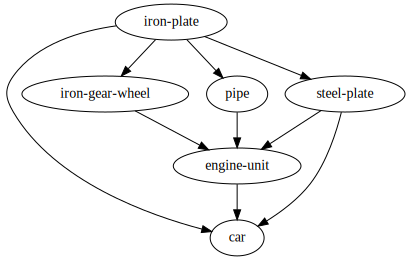

In [6]:
# Scale positions to canvas
def scale(x, y, width, height, margin=50):
    # Graphviz has origin top-left, may need flip y
    # Find min/max for scaling
    xs = [p[0] for p in pos.values()]
    ys = [p[1] for p in pos.values()]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    
    sx = margin + (x - min_x) / (max_x - min_x) * (width - 2*margin)
    sy = margin + (y - min_y) / (max_y - min_y) * (height - 2*margin)
    return sx, sy


A = pgv.AGraph(directed=True)
A.add_edges_from(edges)
A.layout(prog='dot')

A

# root = tk.Tk()
# root.title("Factorio Recipe Graph")
# canvas = tk.Canvas(root, width=800, height=600, bg="white")
# canvas.pack()

# # Example interaction: print node name on click
# def on_click(event):
#     clicked_items = canvas.find_closest(event.x, event.y)
#     for node, nid in node_ids.items():
#         if nid in clicked_items:
#             print(f"Clicked node: {node}")

# canvas.bind("<Button-1>", on_click)

# root.mainloop()

In [7]:
A.edges()[0].attrs['pos']

Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/


AttributeError: 'Edge' object has no attribute 'attrs'

No applications found for mimetype: image/png
.No applications found for mimetype: image/png
./usr/bin/xdg-open: 882: x-www-browser: not found
/usr/bin/xdg-open: 882: x-www-browser: not found
/usr/bin/xdg-open: 882: firefox: not found
/usr/bin/xdg-open: 882: firefox: not found
/usr/bin/xdg-open: 882: iceweasel: not found
/usr/bin/xdg-open: 882: iceweasel: not found
/usr/bin/xdg-open: 882: seamonkey: not found
/usr/bin/xdg-open: 882: seamonkey: not found
/usr/bin/xdg-open: 882: mozilla: not found
/usr/bin/xdg-open: 882: mozilla: not found
/usr/bin/xdg-open: 882: epiphany: not found
/usr/bin/xdg-open: 882: epiphany: not found
/usr/bin/xdg-open: 882: konqueror: not found
/usr/bin/xdg-open: 882: konqueror: not found
/usr/bin/xdg-open: 882: chromium: not found
/usr/bin/xdg-open: 882: chromium: not found
/usr/bin/xdg-open: 882: chromium-browser: not found
/usr/bin/xdg-open: 882: chromium-browser: not found
/usr/bin/xdg-open: 882: google-chrome: not found
/usr/bin/xdg-open: 882: google-chrome